# Predicción de la temperatura

## Descarga de datos csv y scripts

In [1]:
!rm -rf logs
!rm -rf data
!rm -rf regresion
!rm -rf utilidades

In [2]:
!wget https://github.com/rodrigofvc/prediccion-temp-mexico/archive/refs/heads/main.zip

import zipfile

with zipfile.ZipFile("main.zip","r") as zip_ref:
  zip_ref.extractall(".")

!cp -rf "/content/prediccion-temp-mexico-main/data" "."
!cp -rf "/content/prediccion-temp-mexico-main/regresion" "."
!cp -rf "/content/prediccion-temp-mexico-main/utilidades" "."
!rm -rf "prediccion-temp-mexico-main"
!rm -rf "sample_data"
!rm "main.zip"

--2022-11-28 05:04:47--  https://github.com/rodrigofvc/prediccion-temp-mexico/archive/refs/heads/main.zip
Resolving github.com (github.com)... 20.27.177.113
Connecting to github.com (github.com)|20.27.177.113|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/rodrigofvc/prediccion-temp-mexico/zip/refs/heads/main [following]
--2022-11-28 05:04:47--  https://codeload.github.com/rodrigofvc/prediccion-temp-mexico/zip/refs/heads/main
Resolving codeload.github.com (codeload.github.com)... 20.27.177.114
Connecting to codeload.github.com (codeload.github.com)|20.27.177.114|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘main.zip’

main.zip                [                 <=>] 773.93M  7.56MB/s    in 59s     

2022-11-28 05:05:50 (13.2 MB/s) - ‘main.zip’ saved [811529884]



## Import de scripts

In [3]:
from utilidades.Lector_Futuro import Lector_Futuro
from utilidades.Lector import Lector
import sys

## Modelo de redes neuronales

### Import de bibliotecas necesarias

In [4]:
!pip install pytorch-lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

In [6]:
# Utilerias
import os
import math
import random
import datetime
# Redes neuronales
import torch
import torch.nn as nn
import torch.optim as optim
# Matrices
import numpy as np
import pandas as pd
# Lightning
from pytorch_lightning import seed_everything
import pytorch_lightning as pl
import torch.nn.functional as F
from torchvision import datasets, transforms
from pytorch_lightning.loggers import TensorBoardLogger
from torchmetrics import MeanAbsoluteError
# Carga de datos
from torch.utils.data import DataLoader, TensorDataset
# TensorFlow
import tensorflow as tf

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

### Establecer la semilla

In [7]:
SEED = 99
def set_seed(seed):
    """Initializes pseudo-random number generators."""
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
set_seed(SEED)

### Definición del conjunto de datos

https://pytorch-lightning.readthedocs.io/en/latest/data/datamodule.html

In [8]:
from torchmetrics.wrappers.minmax import MinMaxMetric
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

class Data_ENCB_90(pl.LightningDataModule):
  def __init__(self, hora, pasosPasado=1, pasosFuturo=1, excluirColumnasX=['Direcci�n del Viento (grados)','Direcci�n de r�faga (grados)'], agregarHoraLocalY=True, show=True):
    super(Data_ENCB_90, self).__init__()
    
    self.BATCH_SIZE = 128
    self.X = None
    self.Y = None
    self.Y_val_horaLocal = None
    self.ds_trn = None
    self.ds_val = None
    #self.ds_tst = None

    self.pasosPasado = pasosPasado
    self.pasosFuturo = pasosFuturo
    self.excluirColumnasX = excluirColumnasX
    self.hora = hora
    self.agregarHoraLocalY= agregarHoraLocalY
    self.show = show

  def prepare_data(self):
    # Lee los datos del directorio
    l = Lector_Futuro('data/encb-90-fusionado.csv')
    self.X, self.Y = l.get_data(self.hora, pasosPasado=self.pasosPasado, pasosFuturo=self.pasosFuturo, excluirColumnasX=self.excluirColumnasX, agregarHoraLocalY=True, show=self.show)
    
    # El conjunto de datos se filtra a un intervalo especifico
    lp = Lector('data/encb-90-fusionado.csv')
    fecha_cercana = "2022-10-03 " + self.hora
    fecha_lejana = "2022-08-14 " + self.hora
    X_out, Y_out = lp.intervalo(self.X, self.Y, fecha_cercana, fecha_lejana)
    self.X = X_out
    self.Y = Y_out
    #if(self.agregarHoraLocalY == True):
    #  self.Y_val_horaLocal = self.Y.iloc[:,-1:]
    #  self.Y = self.Y.iloc[:,:1]

  def setup(self, stage=None):

    # Se dividen los datos en prueba y entrenamiento
    X_train, X_test, y_train, y_test = train_test_split(self.X, self.Y, random_state=SEED)

    if(self.agregarHoraLocalY == True):
      self.Y_val_horaLocal = y_test.iloc[:,-1:]
      y_test = y_test.iloc[:,:1]
      y_train = y_train.iloc[:,:1]

    # Min Max scaler se entrena con X de entrenamiento
    scaler = MinMaxScaler()
    scaler.fit(X_train)

    # Se escalan ambos X (entrenamiento y prueba) con el scaler previamente
    X_train_scaled = scaler.transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Convierte los datos a un arreglo de números decimales
    X_train_scaled = np.array(X_train_scaled, dtype="float32")
    X_test_scaled = np.array(X_test_scaled, dtype="float32")
    y_train = np.array(y_train, dtype="float32")
    y_test = np.array(y_test, dtype="float32")

    # Convierte el arreglo a un tensor
    X_train_scaled = torch.tensor(X_train_scaled)
    X_test_scaled = torch.tensor(X_test_scaled)
    y_train = torch.tensor(y_train)
    y_test = torch.tensor(y_test)

    # Crea los Dataset de  entrenamiento y prueba
    self.ds_trn = TensorDataset(X_train_scaled, y_train)
    self.ds_val = TensorDataset(X_test_scaled, y_test)

    # Calcula el porcentaje 80/20
    #val_size = int(0.2 * len(dataSet))
    #train_size = len(dataSet) - val_size

    # Divide el Dataset en conjunto de entrenamiento y prueba (aleatorio)
    #self.ds_trn, self.ds_val = torch.utils.data.random_split(dataSet, [train_size, val_size], generator=torch.Generator().manual_seed(SEED))
    #self.Y_val_horaLocal = self.Y_val_horaLocal.iloc[dataTemp.ds_val.indices]

    # Divide el Dataset en conjunto de entrenamiento y prueba (sin aleatoriedad)
    #self.ds_val = torch.utils.data.Subset(dataSet, range(val_size))
    #self.ds_trn = torch.utils.data.Subset(dataSet, range(val_size, val_size + train_size))
    #self.Y_val_horaLocal = self.Y_val_horaLocal.iloc[range(val_size)]
    #self.ds_tst = torch.utils.data.Subset(dataSet, range(val_size + train_size, val_size + train_size + test_size))

  # Devuelte los datos de entrenamiento
  def train_dataloader(self):
    return DataLoader(self.ds_trn, batch_size=self.BATCH_SIZE, shuffle=False)
  
  # Devuelte los datos de validación
  def val_dataloader(self):
    return DataLoader(self.ds_val, batch_size=self.BATCH_SIZE, shuffle=False)

  # Devuelte los datos de prueba
  #def test_dataloader(self):
  #  return DataLoader(self.ds_tst, batch_size=self.BATCH_SIZE, shuffle=False)

### Muestras del conjunto de datos

In [9]:
dataTemp = Data_ENCB_90('14:00:00', pasosPasado=1, pasosFuturo=3, excluirColumnasX=['Direcci�n del Viento (grados)', 'Direcci�n de r�faga (grados)'])
dataTemp.prepare_data()
dataTemp.setup()


---------------
Temperatura de fecha a predecir (Temperatura d_t = 24.4): 2022-11-11 14:00:00
Datos de t-3 días antes: 2022-11-08 14:00:00 [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
Datos pasados final: [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 23.2): 2022-11-10 14:00:00
Datos de t-3 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos pasados final: [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 22.2): 2022-11-09 14:00:00
Datos de t-3 días antes: 2022-11-06 14:00:00 [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
Datos pasados final: [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 21.2): 2022-11-08 14:00:00
Datos de t-3 días antes: 2022-11-05 14:00:00 [6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0]
Datos pasados final: [6.7, 14.9, 24.5, 38

Se obtiene el primer lote de datos para visualizar:

In [10]:
# El número de muestras por lote varia dependiendo del tamaño del lote definido (BATCH_SIZE).
dl = dataTemp.train_dataloader()
x, y = next(iter(dl))

print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
print(f"x = {x}")
print(f"y = {y}")

x shape=torch.Size([38, 7]) dtype=torch.float32
y shape=torch.Size([38, 1]) dtype=torch.float32
x = tensor([[0.1111, 0.3353, 0.7727, 0.4359, 0.3778, 0.0000, 0.6903],
        [0.1414, 0.1676, 0.9091, 0.5128, 0.6222, 0.0000, 0.8210],
        [0.4343, 0.4046, 0.4848, 0.6923, 0.2889, 0.0000, 0.2586],
        [0.6162, 0.6358, 0.0000, 1.0000, 0.7333, 0.0000, 0.0993],
        [0.2323, 0.1676, 0.6667, 0.6923, 0.3111, 0.0000, 0.0816],
        [0.3939, 0.3006, 0.8788, 0.4615, 0.5111, 0.0000, 0.5487],
        [0.3939, 0.5029, 0.7121, 0.6410, 0.2222, 0.0000, 0.0993],
        [0.5657, 0.5665, 0.7273, 0.6410, 0.5333, 0.0000, 0.9666],
        [0.3636, 0.4682, 0.5909, 0.6154, 0.2444, 0.0000, 0.8476],
        [0.0909, 0.1329, 0.9394, 0.3333, 0.2667, 0.0000, 0.4179],
        [0.3434, 0.1676, 0.8030, 0.4872, 0.7778, 0.0000, 0.7306],
        [0.7273, 0.6358, 0.5303, 0.8205, 0.3111, 0.0000, 0.1898],
        [0.4747, 0.4335, 0.7727, 0.6154, 0.4889, 0.0000, 0.8279],
        [0.4040, 0.6705, 0.6364, 0.6923, 0

In [11]:
# El número de muestras por lote varia dependiendo del tamaño del lote definido (BATCH_SIZE).
dl = dataTemp.val_dataloader()
x, y = next(iter(dl))

print(f'x shape={x.shape} dtype={x.dtype}')
print(f'y shape={y.shape} dtype={y.dtype}')
print(f"x = {x}")
print(f"y = {y}")

x shape=torch.Size([13, 7]) dtype=torch.float32
y shape=torch.Size([13, 1]) dtype=torch.float32
x = tensor([[ 0.0101,  0.0347,  0.8182,  0.1282, -0.2000,  0.0000,  0.8378],
        [ 0.2222,  0.2370,  0.8182,  0.7436,  0.1111,  0.0000,  0.9086],
        [ 0.6364,  0.5665,  0.5909,  0.8205,  0.9333,  0.0000,  0.1101],
        [ 0.5051,  0.6705,  0.3485,  1.0513,  0.1778,  0.0000,  0.3196],
        [ 0.3939,  0.6994,  0.9697,  0.3590,  0.1778,  0.0000,  0.9469],
        [ 0.2525,  0.4046,  0.8030,  0.6154,  0.5556,  0.0000,  0.4238],
        [ 0.1717,  0.1329,  0.6970,  0.5897,  0.5333,  0.0000,  0.3825],
        [ 0.2727,  0.1676,  0.7879,  0.6667,  0.3778,  0.0000,  0.3147],
        [ 0.0404,  0.0694,  0.7879,  0.5385,  0.1333,  0.0000,  0.9558],
        [ 0.3434,  0.6012,  0.8636,  0.3333,  0.9111,  0.0000,  0.6735],
        [ 0.2626,  0.3006,  0.9545,  0.5128,  0.4667,  0.0000,  0.6824],
        [ 0.7879,  0.6012,  0.6212,  0.8205,  0.2444,  0.0000,  0.4051],
        [ 0.2424,  0.202

In [12]:
dataTemp.Y_val_horaLocal

,Hora Local
60,2022-09-12 14:00:00
72,2022-08-31 14:00:00
63,2022-09-09 14:00:00
61,2022-09-11 14:00:00
77,2022-08-26 14:00:00
76,2022-08-27 14:00:00
78,2022-08-25 14:00:00
84,2022-08-19 14:00:00
52,2022-09-20 14:00:00
58,2022-09-14 14:00:00


### Definición del modelo

In [13]:
from torch.nn.modules.activation import LeakyReLU
class LinReg(pl.LightningModule):

  def __init__(self, numEntradas, neuronasOcultas=[100,100], lr=0.000001):
    # Se llama al inicializador de la clase padre
    super(LinReg, self).__init__()

    # Se define el numero de entradas y salidas del modelo
    self.numEntradas = numEntradas
    self.numSalidas = 1
    self.neuronasOcultas = neuronasOcultas

    # Se define la tasa de aprendizaje
    self.lr = lr

    # Se define la arquitectura del modelo
    self.fc1 = nn.Linear(self.numEntradas, self.neuronasOcultas[0])
    self.fc2 = nn.Linear(self.neuronasOcultas[0], self.neuronasOcultas[1])
    self.out = nn.Linear(self.neuronasOcultas[1], self.numSalidas)
          
    # Se define la función de pérdida para entrenamiento
    self.loss = nn.MSELoss()
    
  def forward(self, x):
    # Se define la función forward (hacia adelante) del modelo
    if(type(x) is list):
      x = x[0]

    x = self.fc1(x)
    x = F.leaky_relu(x)
    x = self.fc2(x)
    x = F.leaky_relu(x)
    x = self.out(x)
    return x

  def configure_optimizers(self):
    # Se define como optimizador el descenso por gradiente estocástico (con momento)
    return torch.optim.Adam(self.parameters(), lr = self.lr)

  # Se definen los pasos de entrenamiento del modelo
  def training_step(self, train_batch, batch_idx):
    # Se obtienen los datos del lote
    x, y = train_batch
    # Se hace inferencia para obtener los logits
    logits = self.forward(x)
    # Se calcula la pérdida con los datos de entrenamiento
    loss = self.loss(logits, y)
    MAE_obj = MeanAbsoluteError()
    MAE_loss = MAE_obj(logits, y)#nn.L1Loss(logits, y)#(y - logits).abs().mean()
    RMSE_loss = torch.sqrt(loss)#(y - logits).abs().mean()

    output={
      "loss": loss,
      "MAE_loss": MAE_loss,
      "RMSE_loss": RMSE_loss
    }

    # Retorna la pérdida del lote
    return output

  # Se definen los pasos de validación del modelo
  def validation_step(self, valid_batch, batch_idx):
    # Se obtienen los datos del lote
    x, y = valid_batch
    # Se hace inferencia para obtener los logits
    logits = self.forward(x)
    #Se calcula la pérdida con los datos de validación
    loss = self.loss(logits, y)
    MAE_obj = MeanAbsoluteError()
    MAE_loss = MAE_obj(logits, y)#nn.L1Loss(logits, y)#(y - logits).abs().mean()
    RMSE_loss = torch.sqrt(loss)#(y - logits).abs().mean()

    output={
      "loss": loss,
      "MAE_loss": MAE_loss,
      "RMSE_loss": RMSE_loss
    }

    # Retorna la pérdida del lote
    return output

  # Esta función se llama cuando cada época de entrenamiento termina
  def training_epoch_end(self, outputs):

    # Se calcula el promedio de todos los lotes en la época
    avg_loss_trn = torch.stack([x['loss'] for x in outputs]).mean()
    avg_MAE_loss_trn = torch.stack([x['MAE_loss'] for x in outputs]).mean()
    avg_RMSE_loss_trn = torch.stack([x['RMSE_loss'] for x in outputs]).mean()

    # Se manda graficar a TensorBoard
    self.logger.experiment.add_scalar("Pérdida/MSE Entrenamiento",
                                      avg_loss_trn,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/MAE Entrenamiento",
                                      avg_MAE_loss_trn,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/RMSE Entrenamiento",
                                      avg_RMSE_loss_trn,
                                      self.current_epoch)
    
  # Esta función se llama cuando cada época de validación termina
  def validation_epoch_end(self, outputs):

    # Se calcula el promedio de todos los lotes en la época
    avg_loss_val = torch.stack([x['loss'] for x in outputs]).mean()
    avg_MAE_loss_trn = torch.stack([x['MAE_loss'] for x in outputs]).mean()
    avg_RMSE_loss_trn = torch.stack([x['RMSE_loss'] for x in outputs]).mean()

    # Se manda graficar a TensorBoard
    self.logger.experiment.add_scalar("Pérdida/MSE Validación",
                                      avg_loss_val,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/MAE Validación",
                                      avg_MAE_loss_trn,
                                      self.current_epoch)
    self.logger.experiment.add_scalar("Pérdida/RMSE Validación",
                                      avg_RMSE_loss_trn,
                                      self.current_epoch)

### Entrenamiento del modelo

https://pytorch-lightning.readthedocs.io/en/stable/common/trainer.html

#### Experimento con variables meteorológicas

##### 2PM

###### pasosPasado=1, pasosFuturo=3, sin Dirección del viento ni Dirección de la ráfaga

In [29]:
seed_everything(SEED, workers=True)

# Se crea el conjunto de datos
dataENCB90_exp1 = Data_ENCB_90('14:00:00', pasosPasado=1, pasosFuturo=3, excluirColumnasX=['Direcci�n del Viento (grados)', 'Direcci�n de r�faga (grados)'])
dataENCB90_exp1.prepare_data()
# Se crea el modelo
modelLinReg_exp1 = LinReg(dataENCB90_exp1.X.shape[1], neuronasOcultas=[24*2, 12*2], lr=0.2)

# Se inicializan los registros para el entrenamiento y la prueba
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logger = TensorBoardLogger(save_dir = logdir, name="ENCB_90_exp1")

# Comienza el entrenamiento
trainer = pl.Trainer(max_epochs=50, logger=logger, log_every_n_steps=1, deterministic=True, accelerator="auto")
trainer.fit(modelLinReg_exp1, dataENCB90_exp1)

INFO:lightning_lite.utilities.seed:Global seed set to 99



---------------
Temperatura de fecha a predecir (Temperatura d_t = 24.4): 2022-11-11 14:00:00
Datos de t-3 días antes: 2022-11-08 14:00:00 [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
Datos pasados final: [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 23.2): 2022-11-10 14:00:00
Datos de t-3 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos pasados final: [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 22.2): 2022-11-09 14:00:00
Datos de t-3 días antes: 2022-11-06 14:00:00 [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
Datos pasados final: [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 21.2): 2022-11-08 14:00:00
Datos de t-3 días antes: 2022-11-05 14:00:00 [6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0]
Datos pasados final: [6.7, 14.9, 24.5, 38

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



---------------
Temperatura de fecha a predecir (Temperatura d_t = 24.4): 2022-11-11 14:00:00
Datos de t-3 días antes: 2022-11-08 14:00:00 [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
Datos pasados final: [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 23.2): 2022-11-10 14:00:00
Datos de t-3 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos pasados final: [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 22.2): 2022-11-09 14:00:00
Datos de t-3 días antes: 2022-11-06 14:00:00 [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
Datos pasados final: [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 21.2): 2022-11-08 14:00:00
Datos de t-3 días antes: 2022-11-05 14:00:00 [6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0]
Datos pasados final: [6.7, 14.9, 24.5, 38

INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type    | Params
---------------------------------
0 | fc1  | Linear  | 384   
1 | fc2  | Linear  | 1.2 K 
2 | out  | Linear  | 25    
3 | loss | MSELoss | 0     
---------------------------------
1.6 K     Trainable params
0         Non-trainable params
1.6 K     Total params
0.006     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=50` reached.


###### pasosPasado=5, pasosFuturo=3, sin Dirección del viento ni Dirección de la ráfaga

In [28]:
seed_everything(SEED, workers=True)

# Se crea el conjunto de datos
dataENCB90_exp2 = Data_ENCB_90('14:00:00', pasosPasado=5, pasosFuturo=3, excluirColumnasX=['Direcci�n del Viento (grados)', 'Direcci�n de r�faga (grados)'])
dataENCB90_exp2.prepare_data()
# Se crea el modelo
modelLinReg_exp2 = LinReg(dataENCB90_exp2.X.shape[1], neuronasOcultas=[24*2, 12*2], lr=0.01)

# Se inicializan los registros para el entrenamiento y la prueba
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logger = TensorBoardLogger(save_dir = logdir, name="ENCB_90_exp2")

# Comienza el entrenamiento
trainer = pl.Trainer(max_epochs=60, logger=logger, log_every_n_steps=1, deterministic=True, accelerator="auto")
trainer.fit(modelLinReg_exp2, dataENCB90_exp2)

INFO:lightning_lite.utilities.seed:Global seed set to 99



---------------
Temperatura de fecha a predecir (Temperatura d_t = 24.4): 2022-11-11 14:00:00
Datos de t-3 días antes: 2022-11-08 14:00:00 [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
Datos de t-4 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos de t-5 días antes: 2022-11-06 14:00:00 [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
Datos de t-6 días antes: 2022-11-05 14:00:00 [6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0]
Datos de t-7 días antes: 2022-11-04 14:00:00 [10.4, 23.5, 23.8, 47, 777.9, 0.0, 375.0]
Datos pasados final: [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0, 11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0, 6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0, 6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0, 10.4, 23.5, 23.8, 47, 777.9, 0.0, 375.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 23.2): 2022-11-10 14:00:00
Datos de t-3 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos de t-4 días antes: 2022-11-06 14:00:00 [6.4,

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



---------------
Temperatura de fecha a predecir (Temperatura d_t = 24.4): 2022-11-11 14:00:00
Datos de t-3 días antes: 2022-11-08 14:00:00 [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
Datos de t-4 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos de t-5 días antes: 2022-11-06 14:00:00 [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
Datos de t-6 días antes: 2022-11-05 14:00:00 [6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0]
Datos de t-7 días antes: 2022-11-04 14:00:00 [10.4, 23.5, 23.8, 47, 777.9, 0.0, 375.0]
Datos pasados final: [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0, 11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0, 6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0, 6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0, 10.4, 23.5, 23.8, 47, 777.9, 0.0, 375.0]
---------------
---------------
Temperatura de fecha a predecir (Temperatura d_t = 23.2): 2022-11-10 14:00:00
Datos de t-3 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos de t-4 días antes: 2022-11-06 14:00:00 [6.4,

INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type    | Params
---------------------------------
0 | fc1  | Linear  | 1.7 K 
1 | fc2  | Linear  | 1.2 K 
2 | out  | Linear  | 25    
3 | loss | MSELoss | 0     
---------------------------------
2.9 K     Trainable params
0         Non-trainable params
2.9 K     Total params
0.012     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


###### pasosPasado=10, pasosFuturo=3, sin Dirección del viento ni Dirección de la ráfaga

In [27]:
seed_everything(SEED, workers=True)

# Se crea el conjunto de datos
dataENCB90_exp3 = Data_ENCB_90('14:00:00', pasosPasado=10, pasosFuturo=3, excluirColumnasX=['Direcci�n del Viento (grados)', 'Direcci�n de r�faga (grados)'])
dataENCB90_exp3.prepare_data()
# Se crea el modelo
modelLinReg_exp3 = LinReg(dataENCB90_exp3.X.shape[1], neuronasOcultas=[24*2, 12*2], lr=0.008)

# Se inicializan los registros para el entrenamiento y la prueba
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
logger = TensorBoardLogger(save_dir = logdir, name="ENCB_90_exp2")

# Comienza el entrenamiento
trainer = pl.Trainer(max_epochs=60, logger=logger, log_every_n_steps=1, deterministic=True, accelerator="auto")
trainer.fit(modelLinReg_exp3, dataENCB90_exp3)

INFO:lightning_lite.utilities.seed:Global seed set to 99



---------------
Temperatura de fecha a predecir (Temperatura d_t = 24.4): 2022-11-11 14:00:00
Datos de t-3 días antes: 2022-11-08 14:00:00 [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
Datos de t-4 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos de t-5 días antes: 2022-11-06 14:00:00 [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
Datos de t-6 días antes: 2022-11-05 14:00:00 [6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0]
Datos de t-7 días antes: 2022-11-04 14:00:00 [10.4, 23.5, 23.8, 47, 777.9, 0.0, 375.0]
Datos de t-8 días antes: 2022-11-03 14:00:00 [7.3, 9.7, 23.6, 42, 780.4, 0.0, 420.0]
Datos de t-9 días antes: 2022-11-02 14:00:00 [7.8, 13.7, 23.5, 39, 781.1, 0.0, 768.0]
Datos de t-10 días antes: 2022-11-01 14:00:00 [4.1, 6.8, 24.1, 49, 778.8, 0.0, 604.0]
Datos de t-11 días antes: 2022-10-31 14:00:00 [6.9, 16.6, 23.4, 47, 776.7, 0.0, 671.0]
Datos de t-12 días antes: 2022-10-30 14:00:00 [6.1, 10.8, 25.2, 45, 777.6, 0.0, 877.0]
Datos pasados final: [10.0, 21.2, 21.2, 2

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



---------------
Temperatura de fecha a predecir (Temperatura d_t = 24.4): 2022-11-11 14:00:00
Datos de t-3 días antes: 2022-11-08 14:00:00 [10.0, 21.2, 21.2, 28, 781.0, 0.0, 808.0]
Datos de t-4 días antes: 2022-11-07 14:00:00 [11.7, 24.1, 23.7, 16, 779.9, 0.0, 809.0]
Datos de t-5 días antes: 2022-11-06 14:00:00 [6.4, 12.5, 23.7, 40, 778.0, 0.0, 766.0]
Datos de t-6 días antes: 2022-11-05 14:00:00 [6.7, 14.9, 24.5, 38, 777.3, 0.0, 702.0]
Datos de t-7 días antes: 2022-11-04 14:00:00 [10.4, 23.5, 23.8, 47, 777.9, 0.0, 375.0]
Datos de t-8 días antes: 2022-11-03 14:00:00 [7.3, 9.7, 23.6, 42, 780.4, 0.0, 420.0]
Datos de t-9 días antes: 2022-11-02 14:00:00 [7.8, 13.7, 23.5, 39, 781.1, 0.0, 768.0]
Datos de t-10 días antes: 2022-11-01 14:00:00 [4.1, 6.8, 24.1, 49, 778.8, 0.0, 604.0]
Datos de t-11 días antes: 2022-10-31 14:00:00 [6.9, 16.6, 23.4, 47, 776.7, 0.0, 671.0]
Datos de t-12 días antes: 2022-10-30 14:00:00 [6.1, 10.8, 25.2, 45, 777.6, 0.0, 877.0]
Datos pasados final: [10.0, 21.2, 21.2, 2

INFO:pytorch_lightning.callbacks.model_summary:
  | Name | Type    | Params
---------------------------------
0 | fc1  | Linear  | 3.4 K 
1 | fc2  | Linear  | 1.2 K 
2 | out  | Linear  | 25    
3 | loss | MSELoss | 0     
---------------------------------
4.6 K     Trainable params
0         Non-trainable params
4.6 K     Total params
0.018     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=60` reached.


### Visualización de resultados

#### TensorBoard

In [17]:
%tensorboard --logdir="logs"

<IPython.core.display.Javascript object>

In [18]:
#best_model_path = trainer.checkpoint_callback.best_model_path
#print(best_model_path)

#model = modelLinReg.load_from_checkpoint(best_model_path)
#model.eval()

#with torch.no_grad():
#    x = torch.Tensor([[[290.0000, 273.0000,   6.3000,  10.2000, 98.0000, 782.3000,0.0000,0.0000]]]) #y_true 13.1
#    y_lgts = model(x)
#    print(y_lgts)

#### Cálculo de predicciones y métricas

###### 2PM pasosPasado=1, pasosFuturo=3, sin Dirección del viento ni Dirección de la ráfaga

In [30]:
dataENCB90_exp1.show = False
predictions_exp1 = trainer.predict(modelLinReg_exp1, dataENCB90_exp1.val_dataloader())
predictions_list_exp1 = []
for prediction in predictions_exp1[0]:
  predictions_list_exp1.append(float(prediction))
#predictions_list_exp1
test_batch_exp1 = next(iter(dataENCB90_exp1.val_dataloader()))
#test_batch[1]

true_list_exp1 = []
for true in test_batch_exp1[1]:
  true_list_exp1.append(float(true))
true_list_exp1
#dataENCB90.Y_val_horaLocal

lossgraph_exp1 = r2_score(true_list_exp1, predictions_list_exp1) # R2
lossgraph1_exp1 = mean_squared_error(true_list_exp1, predictions_list_exp1) #MSE
lossgraph2_exp1 = mean_squared_error(true_list_exp1, predictions_list_exp1, squared= False) #RMSE
lossgraph3_exp1 = mean_absolute_error(true_list_exp1, predictions_list_exp1) #MAE

Predicting: 1it [00:00, ?it/s]

###### 2PM pasosPasado=5, pasosFuturo=3, sin Dirección del viento ni Dirección de la ráfaga

In [31]:
dataENCB90_exp2.show = False
predictions_exp2 = trainer.predict(modelLinReg_exp2, dataENCB90_exp2.val_dataloader())
predictions_list_exp2 = []
for prediction in predictions_exp2[0]:
  predictions_list_exp2.append(float(prediction))
#predictions_list_exp1
test_batch_exp2 = next(iter(dataENCB90_exp2.val_dataloader()))
#test_batch[1]

true_list_exp2 = []
for true in test_batch_exp2[1]:
  true_list_exp2.append(float(true))
true_list_exp2
#dataENCB90.Y_val_horaLocal

lossgraph_exp2 = r2_score(true_list_exp2, predictions_list_exp2) # R2
lossgraph1_exp2 = mean_squared_error(true_list_exp2, predictions_list_exp2) #MSE
lossgraph2_exp2 = mean_squared_error(true_list_exp2, predictions_list_exp2, squared= False) #RMSE
lossgraph3_exp2 = mean_absolute_error(true_list_exp2, predictions_list_exp2) #MAE

Predicting: 1it [00:00, ?it/s]

###### 2PM pasosPasado=10, pasosFuturo=3, sin Dirección del viento ni Dirección de la ráfaga

In [32]:
dataENCB90_exp3.show = False
predictions_exp3 = trainer.predict(modelLinReg_exp3, dataENCB90_exp3.val_dataloader())
predictions_list_exp3 = []
for prediction in predictions_exp3[0]:
  predictions_list_exp3.append(float(prediction))
#predictions_list_exp1
test_batch_exp3 = next(iter(dataENCB90_exp3.val_dataloader()))
#test_batch[1]

true_list_exp3 = []
for true in test_batch_exp3[1]:
  true_list_exp3.append(float(true))
true_list_exp3
#dataENCB90.Y_val_horaLocal

lossgraph_exp3 = r2_score(true_list_exp3, predictions_list_exp3) # R2
lossgraph1_exp3 = mean_squared_error(true_list_exp3, predictions_list_exp3) #MSE
lossgraph2_exp3 = mean_squared_error(true_list_exp3, predictions_list_exp3, squared= False) #RMSE
lossgraph3_exp3 = mean_absolute_error(true_list_exp3, predictions_list_exp3) #MAE

Predicting: 1it [00:00, ?it/s]

#### Gráficas del conjunto de prueba

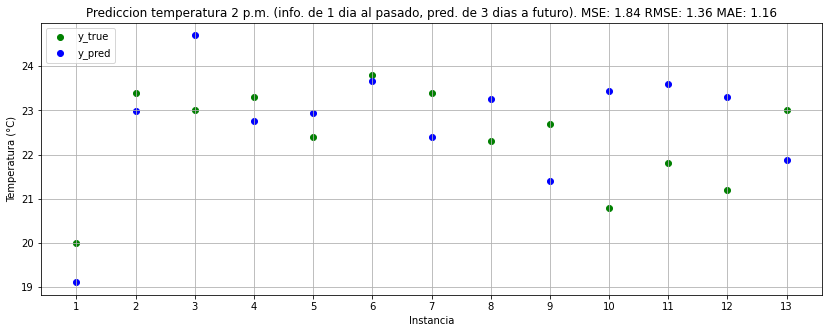

In [33]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import matplotlib.dates as mdates
# Muestra la grafica con las predicciones de dias futuros
fig1 = plt.figure()
axs1 = fig1.add_subplot(1, 1, 1)
axs1.set_xlabel("Instancia")
axs1.set_ylabel("Temperatura (°C)")
plt.scatter(np.arange(1,len(true_list_exp1)+1), true_list_exp1, color="green", marker="o", label='y_true')
plt.scatter(np.arange(1,len(predictions_list_exp1)+1), predictions_list_exp1, color="blue", marker="o", label='y_pred')
axs1.legend(loc="upper left")
axs1.set_title(f'Prediccion temperatura 2 p.m. (info. de 1 dia al pasado, pred. de 3 dias a futuro). MSE: {lossgraph1_exp1:.2f} RMSE: {lossgraph2_exp1:.2f} MAE: {lossgraph3_exp1:.2f}')
fig1.set_size_inches(14,5)
plt.xticks(np.arange(1,len(true_list_exp1)+1))
plt.grid()
fig1.savefig('redes-exp1-pred.png')

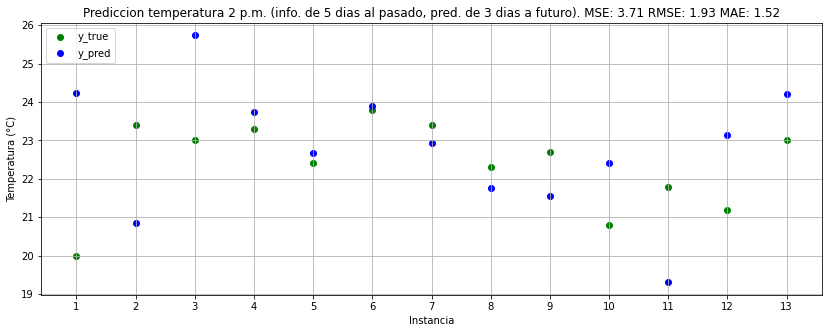

In [34]:
# Muestra la grafica
fig1 = plt.figure()
axs1 = fig1.add_subplot(1, 1, 1)
axs1.set_xlabel("Instancia")
axs1.set_ylabel("Temperatura (°C)")
plt.scatter(np.arange(1,len(true_list_exp2)+1), true_list_exp2, color="green", marker="o", label='y_true')
plt.scatter(np.arange(1,len(predictions_list_exp2)+1), predictions_list_exp2, color="blue", marker="o", label='y_pred')
axs1.legend(loc="upper left")
axs1.set_title(f'Prediccion temperatura 2 p.m. (info. de 5 dias al pasado, pred. de 3 dias a futuro). MSE: {lossgraph1_exp2:.2f} RMSE: {lossgraph2_exp2:.2f} MAE: {lossgraph3_exp2:.2f}')
fig1.set_size_inches(14,5)
plt.xticks(np.arange(1,len(true_list_exp2)+1))
plt.grid()
fig1.savefig('redes-exp2-pred.png')

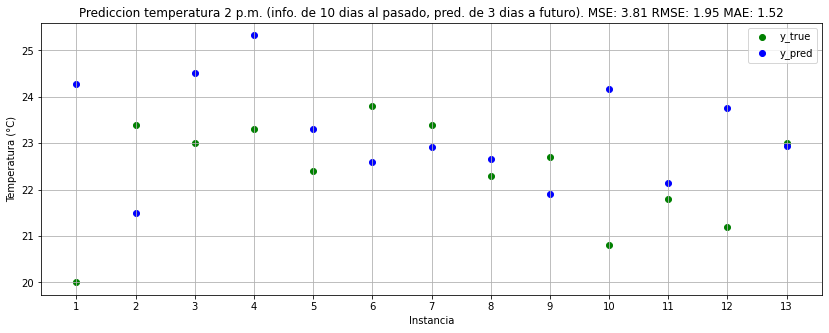

In [35]:
# Muestra la grafica
fig1 = plt.figure()
axs1 = fig1.add_subplot(1, 1, 1)
axs1.set_xlabel("Instancia")
axs1.set_ylabel("Temperatura (°C)")
plt.scatter(np.arange(1,len(true_list_exp3)+1), true_list_exp3, color="green", marker="o", label='y_true')
plt.scatter(np.arange(1,len(predictions_list_exp3)+1), predictions_list_exp3, color="blue", marker="o", label='y_pred')
axs1.legend(loc="upper right")
axs1.set_title(f'Prediccion temperatura 2 p.m. (info. de 10 dias al pasado, pred. de 3 dias a futuro). MSE: {lossgraph1_exp3:.2f} RMSE: {lossgraph2_exp3:.2f} MAE: {lossgraph3_exp3:.2f}')
fig1.set_size_inches(14,5)
plt.xticks(np.arange(1,len(true_list_exp3)+1))
plt.grid()
fig1.savefig('redes-exp3-pred.png')

In [25]:
# import matplotlib.pyplot as plt
# from matplotlib.pyplot import figure
# import matplotlib.dates as mdates
# # Muestra la grafica con las predicciones de dias futuros
# fig1 = plt.figure()
# axs1 = fig1.add_subplot(1, 1, 1)
# axs1.set_xlabel("Fecha (YYYY-MM-DD)")
# axs1.set_ylabel("Temperatura (°C)")
# axs1.plot(dataENCB90.Y_val_horaLocal.to_numpy().reshape(dataENCB90.Y_val_horaLocal.shape[0]),true_list, '-o', label='y_true')
# axs1.plot(dataENCB90.Y_val_horaLocal.to_numpy().reshape(23),predictions_list, '-o', label='y_pred')
# axs1.legend(loc="lower left")
# axs1.set_title('Prediccion temperatura 9 a.m. (1 dia a futuro)')
# fig1.set_size_inches(14,5)
# plt.grid()
# #plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%M-%D'))
# plt.gca().xaxis.set_major_locator(mdates.DayLocator(interval=1))
# plt.gca().tick_params(axis='x', labelrotation=45)
# fig1.savefig('redes-exp3-pred.png')

## Descargar metricas y modelo

In [26]:
!zip -r /content/logs111122_04_40.zip /content/logs

from google.colab import files
files.download("/content/logs111122_04_40.zip")

  adding: content/logs/ (stored 0%)
  adding: content/logs/20221128-050709/ (stored 0%)
  adding: content/logs/20221128-050709/ENCB_90_exp2/ (stored 0%)
  adding: content/logs/20221128-050709/ENCB_90_exp2/version_0/ (stored 0%)
  adding: content/logs/20221128-050709/ENCB_90_exp2/version_0/checkpoints/ (stored 0%)
  adding: content/logs/20221128-050709/ENCB_90_exp2/version_0/checkpoints/epoch=69-step=70.ckpt (deflated 17%)
  adding: content/logs/20221128-050709/ENCB_90_exp2/version_0/hparams.yaml (stored 0%)
  adding: content/logs/20221128-050709/ENCB_90_exp2/version_0/events.out.tfevents.1669612034.4588ed8d5613 (deflated 74%)
  adding: content/logs/20221128-050616/ (stored 0%)
  adding: content/logs/20221128-050616/ENCB_90_exp1/ (stored 0%)
  adding: content/logs/20221128-050616/ENCB_90_exp1/version_0/ (stored 0%)
  adding: content/logs/20221128-050616/ENCB_90_exp1/version_0/events.out.tfevents.1669611977.4588ed8d5613 (deflated 74%)
  adding: content/logs/20221128-050616/ENCB_90_exp1/v

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>